In [1]:
import torch
from torch import nn

### Домашнее задание
**Разработчик: Тимофей Науменко**

На основании функции по варианту необходимо:
1. Построить nn.Module, в котором вы определите `forward`и `my_forward_backward`
2. `forward` должен повторять функцию, выданную вам по варианту, `my_forward_backward` описывает проход по вычислителному графу, а также вычисление градиентов по этому графу с помощью backprop. Градиенты должны быть рассчитаны для параметров $w0, w1$, тензоры $x1, x2, x3$ считаются входными данными сети
3. Необходимо удалять неиспользуемые тензоры, как это делает Pytorch
4. Если какие-то узлы не нужны для вычисления результата, то вы не должны их вычислять в процессе backprop
5. Необходимо построить визуализацию вычислительного графа

Все материалы для выполнения задания можно найти в ноутбуках второго и третьего семинаров, а также в этом ноутбуке есть пример выполненного задания

In [1]:
def v10():  # Александр Щелоков
  r1 = w0 * x3 * w1 + w1 * x2 + x3 ** 2
  r2 = (x3 + w1) * (x1 ** 3 - x2 ** 2)
  r3 = x2 ** 3 * w1 / w0
  return (r1 * r2 * r3 + x3) / (x2 + r2 + r3)

In [9]:
def test_model_class(model_class):

    model = model_class()

    for _ in range(10):

        x1, x2, x3 = torch.rand(3)

        model.zero_grad()
        y_torch = model(x1, x2, x3)
        y_torch.backward()
        grad_torch = model.w.grad.clone()

        # print(y_torch.clone().detach().numpy(), grad_torch.clone().numpy())

        model.zero_grad()
        with torch.no_grad():
            y_manual = model.your_forward_backward(x1, x2, x3)
        grad_manual = model.w.grad.clone()

        # print(y_manual.numpy(), grad_manual.numpy())
        # print()

        assert torch.allclose(y_manual, y_torch, rtol=5e-05, atol=1e-7)
        assert torch.allclose(grad_manual, grad_torch, rtol=5e-05, atol=1e-7)

    print('Tests completed successfully!')

In [10]:
# Пример

class Graph(nn.Module):

    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.tensor([0.950, 0.288], dtype=torch.float32))

    def forward(self, x1, x2, x3):
        r1 = x3 * (x1 / x2 + self.w[1] / self.w[0])
        r2 = x1 * x2 * x3 / (self.w[0] + self.w[1])
        r3 = (self.w[0] * self.w[1]) ** 3.0
        return (r1 + r2 + r3) / (x1 * r1 + r2 + r3)

    def your_forward_backward(self, x1, x2, x3):
        w0 = self.w[0]
        w1 = self.w[1]

        # forward
        a0 = x1 / x2
        a1 = w1 / w0
        a2 = a0 + a1

        a0 = a1 = None

        a3 = x3 * a2 # r1

        a2 = None

        a4 = w0 + w1
        a5 = x1 * x2

        x2 = None

        a6 = a5 * x3

        a5 = None

        a7 = a6 / a4 # r2

        a8 = w0 * w1
        a9 = a8 ** 3 # r3
        a10 = a7 + a9 # r2 + r3

        a7 = a9 = None

        a11 = a10 + a3
        a12 = x1 * a3

        a3 = None

        a13 = a12 + a10

        a10 = a12 = None

        a14 = a11 / a13

        # backward
        da14 = 1.0
        da13 = da14 * ( - a11 / a13**2)

        a11 = None

        da12 = da13
        da11 = da14 * (1 / a13)

        a13 = da14 = None

        da10 = da11 + da13

        da13 = None

        da9 = da10

        da8 = da9 * 3 * a8 ** 2

        da9 = a8 = None

        da7 = da10

        da10 = None

        # da6 и da5 не нужны для вычисления итогового градиента

        da4 = da7 * ( - a6 / a4 ** 2)

        da7 = a6 = a4 = None

        da3 = da11 + da12 * x1

        da11 = da12 = x1 = None

        da2 = da3 * x3

        x3 = da3 = None

        da1 = da2

        da2 = None

        dw1 = da8 * w0 + da4 + da1 / w0
        dw0 = da8 * w1 + da1 * (- w1 / w0 ** 2) + da4

        da1 = da4 = da8 = w0 = w1 = None

        self.w.grad = torch.stack([dw0, dw1])

        return a14

In [11]:
# Здесь тестируется построенная вами модель
test_model_class(Graph)

2.7686517 [-2.0396    -2.0666542]
2.7686515 [-2.0395992 -2.066653 ]

1.5183607 [0.05559397 0.36008665]
1.5183607 [0.05559397 0.36008665]

12.777453 [-38.254173 -57.529144]
12.777452 [-38.254173 -57.52914 ]

2.5307074 [-0.09237211 -0.3035827 ]
2.5307074 [-0.09237211 -0.3035827 ]

1.0409409 [-0.01721919 -0.05388945]
1.0409408 [-0.01721916 -0.05388921]

1.5824147 [-0.03003636 -0.01038443]
1.5824147 [-0.03003636 -0.01038443]

1.1811012 [-0.00559617 -0.02127416]
1.1811012 [-0.00559617 -0.02127416]

3.3448386 [-2.2649453 -5.2997155]
3.3448386 [-2.2649453 -5.2997155]

1.6973048 [0.03849977 0.3899026 ]
1.6973048 [0.03849979 0.38990265]

3.5282257 [-3.8331814 -3.3280644]
3.528226 [-3.8331819 -3.3280659]

Tests completed successfully!


In [5]:
# А сюда вы должны вставить визуализацию графа

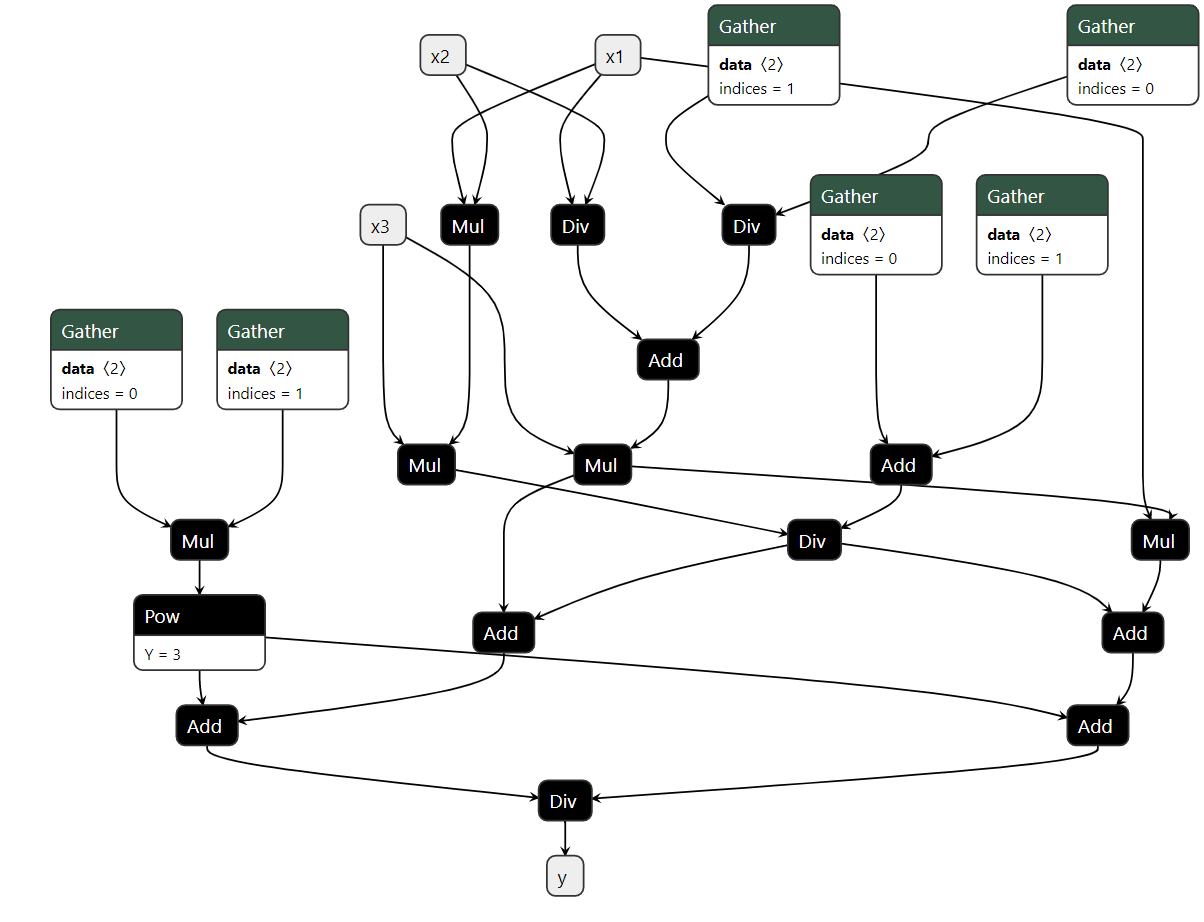